<a href="https://colab.research.google.com/github/nicoleolivetto/CNN/blob/main/AE_covid_date.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [96]:
covid_ds =pd.read_csv("covid_ds.csv")
covid_ds

,Unnamed: 0,Date,Region_code,Region_name,latitude,longitude,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0,2020-02-24T18:00:00,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5
1,1,2020-02-24T18:00:00,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0
2,2,2020-02-24T18:00:00,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1
3,3,2020-02-24T18:00:00,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10
4,4,2020-02-24T18:00:00,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,0,18,0,0,18,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,1717,2020-05-15T17:00:00,19,Sicilia,38.115697,13.362357,198,11,209,1551,1760,-94,8,1351,263,3374,112929
1718,1718,2020-05-15T17:00:00,9,Toscana,43.769231,11.255889,238,67,305,2863,3168,-220,24,5739,976,9883,197365
1719,1719,2020-05-15T17:00:00,10,Umbria,43.106758,12.388247,25,2,27,63,90,-2,2,1259,73,1422,53801
1720,1720,2020-05-15T17:00:00,2,Valle d'Aosta,45.737503,7.320149,37,0,37,40,77,-3,6,953,142,1172,11413


In [97]:
# Convert 'Date' to datetime
covid_ds['Date'] = pd.to_datetime(covid_ds['Date'])

# Normalize numeric columns
numeric_columns = ['latitude', 'longitude', 'hospitalized_with_symptoms', 'intensive_care_petients',
                    'total_hospitalized_patients', 'home_isolation', 'current_positive_cases',
                    'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases',
                    'tests_performed']


scaler = MinMaxScaler()
covid_ds[numeric_columns] = scaler.fit_transform(covid_ds[numeric_columns])

# One-hot encode 'Region_name'
covid_ds = pd.get_dummies(covid_ds, columns=['Region_name', 'Region_code'])

print(covid_ds[numeric_columns])

      latitude  longitude  hospitalized_with_symptoms  \
0     0.505213   0.636656                    0.000000   
1     0.301036   0.888741                    0.000000   
2     0.094264   0.971409                    0.000000   
3     0.324903   0.725939                    0.000000   
4     0.760848   0.421230                    0.000828   
...        ...        ...                         ...   
1717  0.000000   0.632876                    0.016395   
1718  0.674353   0.412239                    0.019707   
1719  0.595334   0.530846                    0.002070   
1720  0.909129   0.000000                    0.003064   
1721  0.873035   0.525630                    0.025751   

      intensive_care_petients  total_hospitalized_patients  home_isolation  \
0                    0.000000                     0.000000        0.000000   
1                    0.000000                     0.000000        0.000000   
2                    0.000000                     0.000000        0.000000   
3  

In [98]:
# Assuming 'cutoff_date' is the specific date you choose
cutoff_date = pd.to_datetime('2020-04-10')

# Split the dataset
train_data = covid_ds[covid_ds['Date'] < cutoff_date]
test_data = covid_ds[covid_ds['Date'] >= cutoff_date]

# Specify the columns relevant for the autoencoder
autoencoder_columns = ['hospitalized_with_symptoms', 'intensive_care_petients', 'total_hospitalized_patients', 'home_isolation', 'current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases', 'tests_performed']

train_data = train_data[autoencoder_columns].values
test_data = test_data[autoencoder_columns].values

In [99]:

# Assuming your input shape is the number of features in your dataset
input_shape = train_data.shape[1]

# Define the autoencoder model
model = models.Sequential()

# Encoder
model.add(layers.InputLayer(input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Decoder
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(input_shape, activation='sigmoid'))  # Output layer, use 'sigmoid' for non-negative inputs

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use 'mse' (Mean Squared Error) loss for reconstruction tasks

# Print the model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 64)                768       
                                                                 
 dense_57 (Dense)            (None, 32)                2080      
                                                                 
 dense_58 (Dense)            (None, 64)                2112      
                                                                 
 dense_59 (Dense)            (None, 11)                715       
                                                                 
Total params: 5675 (22.17 KB)
Trainable params: 5675 (22.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
covid_ds.dtypes

Unnamed: 0                                    int64
Date                                 datetime64[ns]
latitude                                    float64
longitude                                   float64
hospitalized_with_symptoms                  float64
intensive_care_petients                     float64
total_hospitalized_patients                 float64
home_isolation                              float64
current_positive_cases                      float64
change_in_total_positives                   float64
new_positive_cases                          float64
recovered                                   float64
deceased                                    float64
total_cases                                 float64
tests_performed                             float64
Region_name_Abruzzo                           uint8
Region_name_Basilicata                        uint8
Region_name_Calabria                          uint8
Region_name_Campania                          uint8
Region_name_

In [101]:
# Train the model
model.fit(train_data, train_data, epochs=100, batch_size=512, validation_data=(test_data, test_data))

Epoch 1/100
2/2 [==============================] - 1s 166ms/step - loss: 0.2027 - val_loss: 0.1723
Epoch 2/100
2/2 [==============================] - 0s 31ms/step - loss: 0.1991 - val_loss: 0.1691
Epoch 3/100
2/2 [==============================] - 0s 30ms/step - loss: 0.1953 - val_loss: 0.1657
Epoch 4/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1913 - val_loss: 0.1621
Epoch 5/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1870 - val_loss: 0.1581
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1823 - val_loss: 0.1537
Epoch 7/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1773 - val_loss: 0.1489
Epoch 8/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1717 - val_loss: 0.1437
Epoch 9/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1658 - val_loss: 0.1382
Epoch 10/100
2/2 [==============================] - 0s 48ms/step - loss: 0.1593 - val_loss: 0.1322
Epoch 11/100
2/2 [

In [102]:
# Predict on test data
reconstructed_data = model.predict(test_data)


24/24 [==============================] - 0s 2ms/step


In [103]:
# Predict on test data to impute missing values
reconstructed_test_data = model.predict(test_data)

24/24 [==============================] - 0s 2ms/step


24/24 [==============================] - 0s 2ms/step


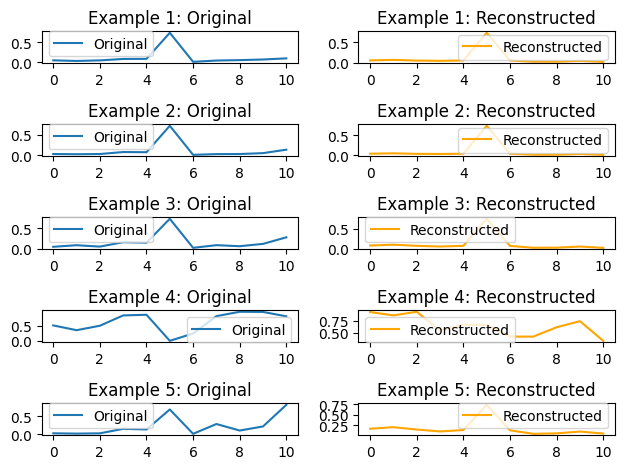

In [104]:
import matplotlib.pyplot as plt

# Predict on test data
reconstructed_data = model.predict(test_data)

# Choose a few random examples for visualization
num_examples = 5
examples_indices = np.random.choice(len(test_data), num_examples, replace=False)

# Plot original and reconstructed data
for i, example_index in enumerate(examples_indices, 1):
    plt.subplot(num_examples, 2, 2 * i - 1)
    plt.plot(test_data[example_index], label='Original')
    plt.title(f'Example {i}: Original')
    plt.legend()

    plt.subplot(num_examples, 2, 2 * i)
    plt.plot(reconstructed_data[example_index], label='Reconstructed', color='orange')
    plt.title(f'Example {i}: Reconstructed')
    plt.legend()

plt.tight_layout()
plt.show()

In [105]:
print(reconstructed_data)


[[0.03334681 0.04162854 0.03094695 ... 0.01491347 0.02979268 0.01247891]
 [0.02445942 0.03006894 0.02258915 ... 0.01202026 0.02413015 0.00981962]
 [0.02703824 0.03340562 0.02498767 ... 0.01284814 0.0258     0.01058299]
 ...
 [0.02634314 0.03247225 0.02430688 ... 0.01251206 0.02532177 0.01037378]
 [0.02512288 0.03087459 0.02313446 ... 0.0122831  0.02472181 0.01011929]
 [0.16165932 0.19910131 0.1427657  ... 0.05339455 0.09599244 0.04937954]]


In [106]:
print(test_data)

[[0.02525462 0.03837799 0.02686074 ... 0.01284797 0.02394227 0.03286307]
 [0.00488532 0.01086169 0.00555222 ... 0.00097333 0.00366148 0.00671506]
 [0.01391074 0.01013758 0.01365546 ... 0.00421777 0.01071102 0.03022683]
 ...
 [0.00207005 0.00144823 0.00202581 ... 0.00473688 0.01690462 0.09774802]
 [0.00306367 0.         0.00277611 ... 0.0092142  0.01393264 0.02073564]
 [0.02575143 0.01737871 0.02513505 ... 0.11433392 0.22455093 0.88051344]]
